## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from openpyxl import Workbook, load_workbook
from openpyxl.styles import Font

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from utils.layer_wrappers import ModuleWrapperLinear, ModuleWrapperConv1d
from layers.BayesianConv1d import BayesianConv1d
from layers.BayesianLinear import BayesianLinear

## Parameters

In [2]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
KL_WEIGHT = 1e-8
EPOCHS = 15
T = 15

PRIORS = {
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0.0, 0.1),
    'posterior_rho_initial': (-3.0, 0.1)
}  

SITE = 'B'
YEAR = 2020

flag_subsampled = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [3]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


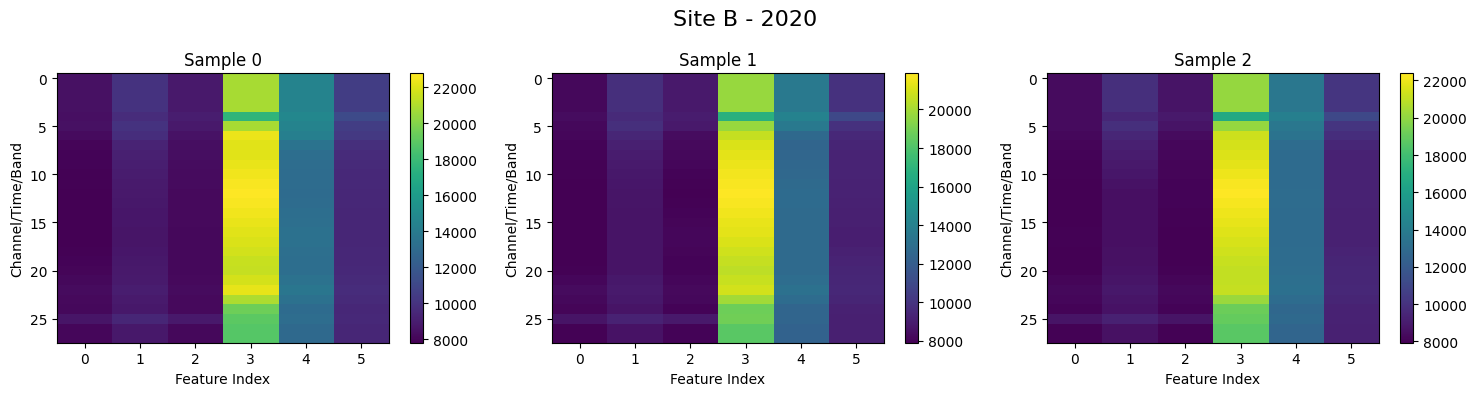

In [4]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [5]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


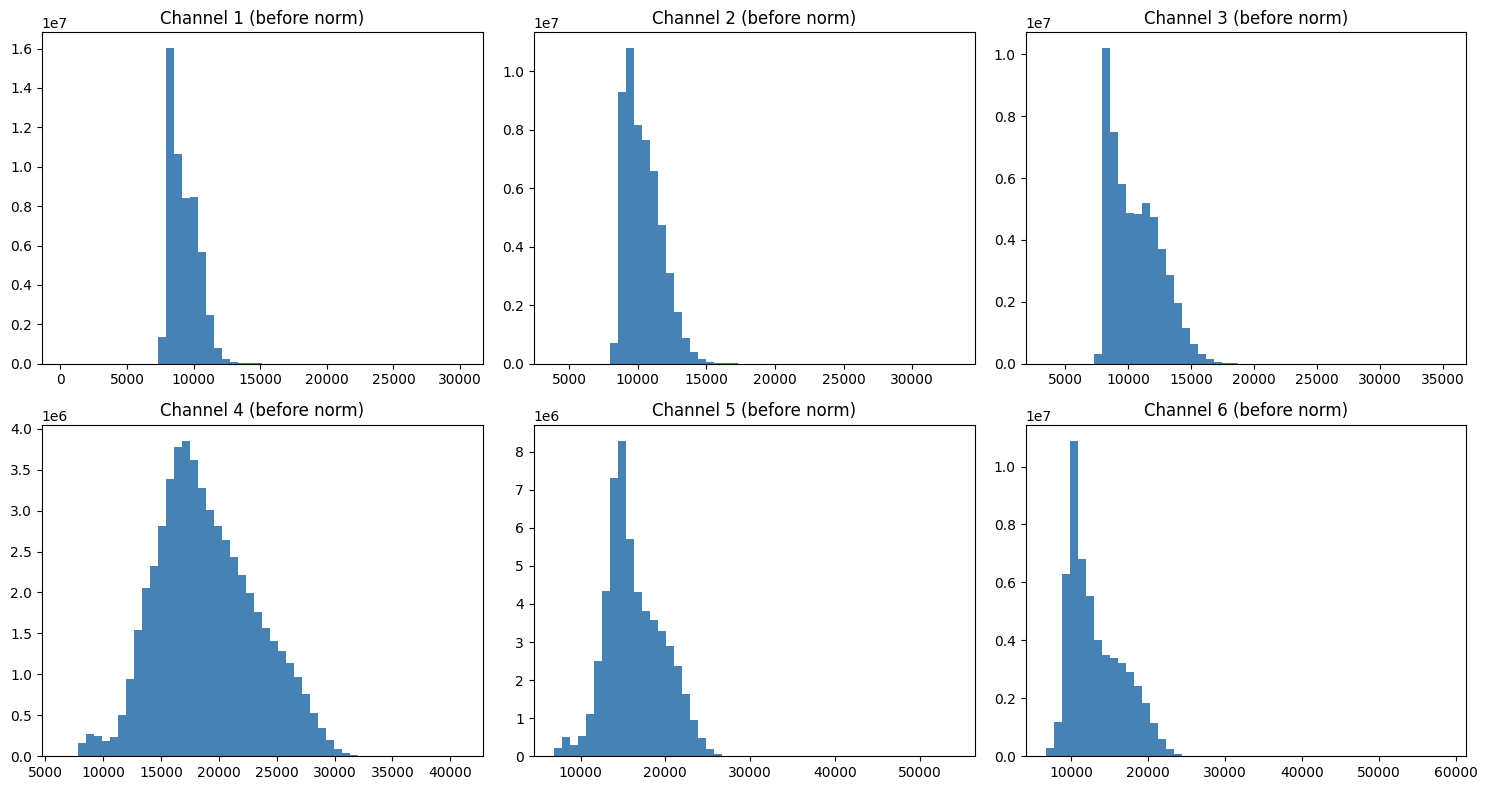

In [6]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Preprocessing the Input

In [7]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

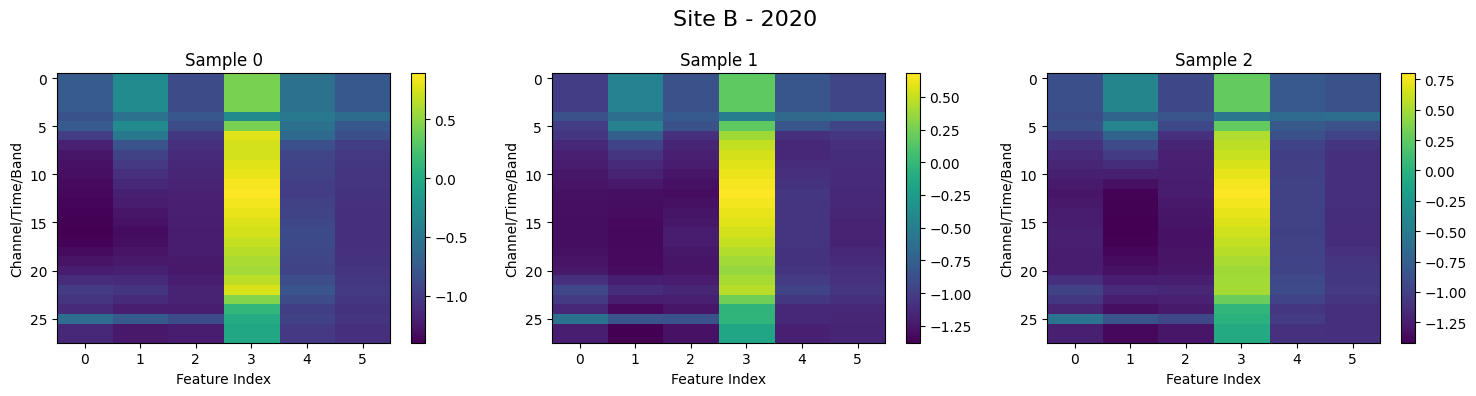

In [8]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


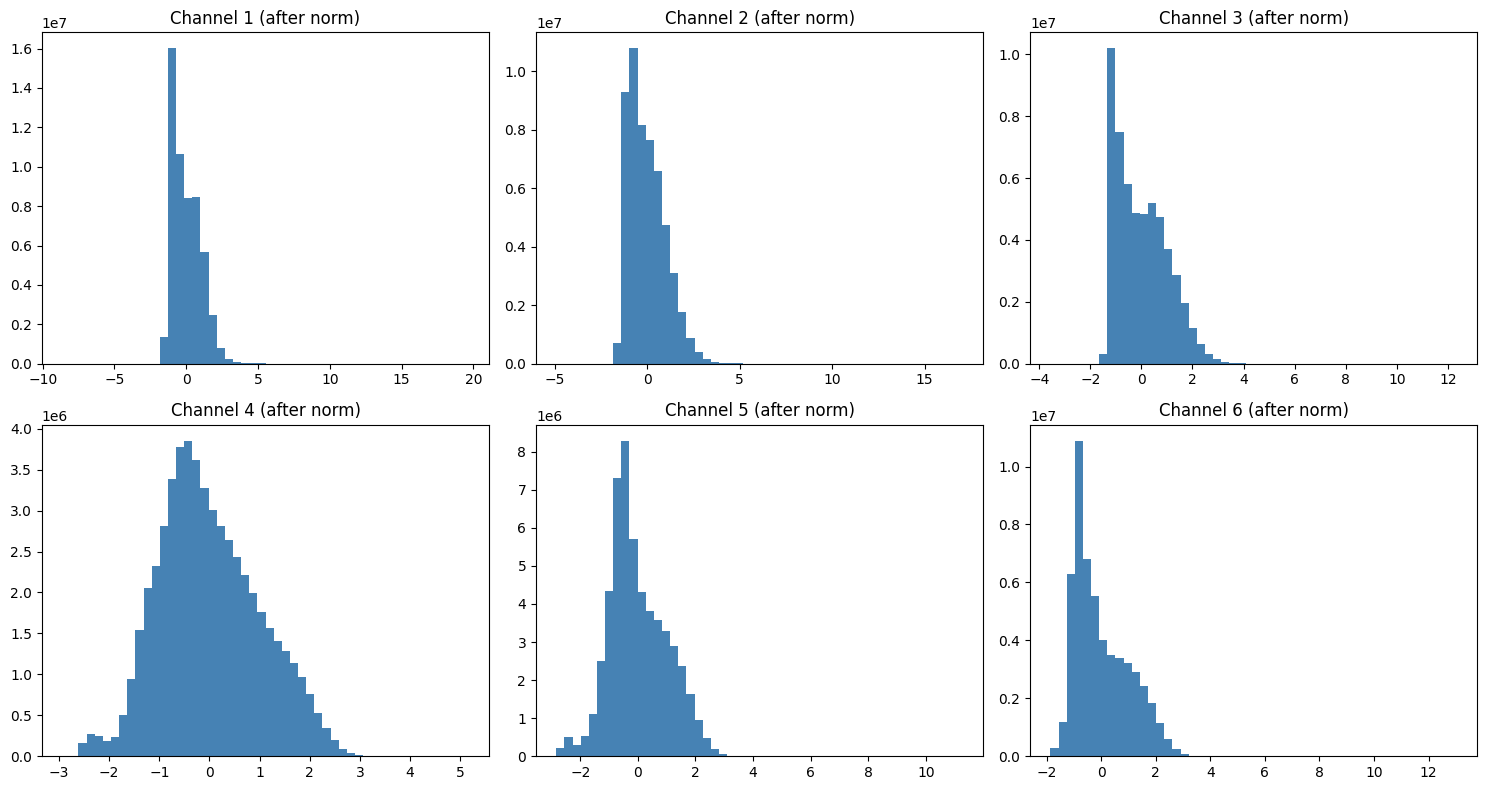

In [10]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


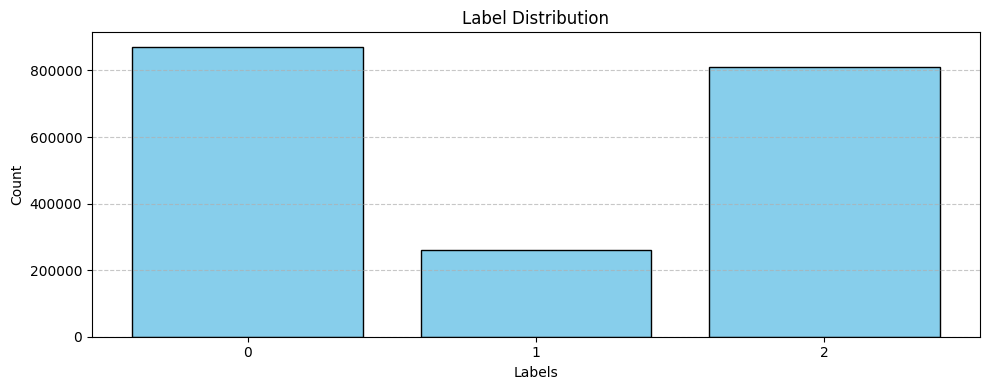

In [11]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [12]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [13]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [14]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


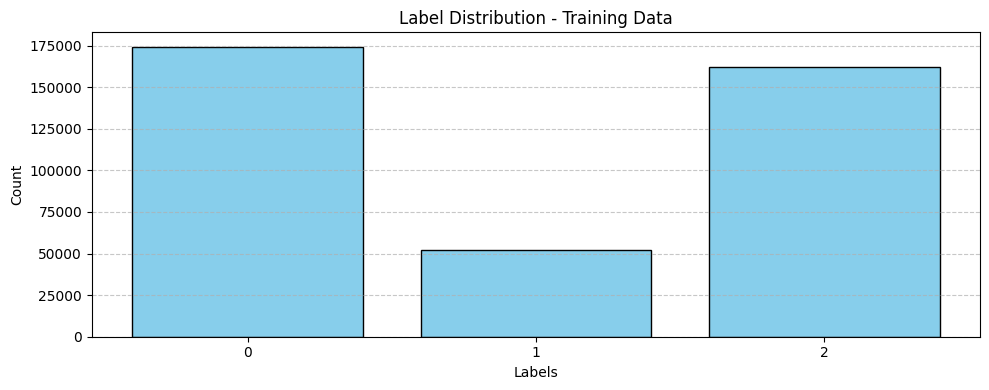

In [15]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [16]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
train_dataset = Conv1dDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [18]:
# Blocks (Conv + FC) 
# ----------------------------
class Conv1d_BayesBlock(ModuleWrapperConv1d):
    """BBBConv1d + BN + ReLU inside a Conv1d wrapper"""
    def __init__(self, in_ch, out_ch, kernel_size, priors, device='cpu', padding=0):
        super().__init__()
        self.conv = BayesianConv1d(in_ch, out_ch, kernel_size, padding=padding, priors=priors, device=device)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.ReLU()

class FCBayesBlock(ModuleWrapperLinear):
    """BBBLinear (optionally add activation if you want)"""
    def __init__(self, in_f, out_f, priors, device='cpu'):
        super().__init__()
        self.fc = BayesianLinear(in_f, out_f, priors=priors, device=device)

In [19]:
########################################
# Bayesian CNN + FC Model
########################################
class BayesianCNN_FC(nn.Module):
    def __init__(self, in_channels=6,  num_classes=3, priors=None, device='cpu'):
        super().__init__()
        self.device = device
        self.conv1 = Conv1d_BayesBlock(in_channels, 64, 5, priors, device=device, padding=2)
        self.conv2 = Conv1d_BayesBlock(64, 128, 5, priors, device=device, padding=2)
        self.conv3 = Conv1d_BayesBlock(128, 256, 5, priors, device=device, padding=2)
        self.conv4 = Conv1d_BayesBlock(256, 512, 5, priors, device=device, padding=2)
        self.conv5 = Conv1d_BayesBlock(512, 1024, 5, priors, device=device, padding=2)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = FCBayesBlock(1024, num_classes, priors, device=device)

    def forward(self, x, sample=True, n_samples=1):
        # x: (batch, channels, length)  OR  (n_samples, batch, channels, length)
        kl_total = torch.tensor(0.0, device=x.device)

        x, kl = self.conv1(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv2(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv3(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv4(x, sample=sample, n_samples=n_samples); kl_total += kl
        x, kl = self.conv5(x, sample=sample, n_samples=n_samples); kl_total += kl

        # global pool (handle sample dim)
        if x.dim() == 4:  # (T, B, C, L)
            T_, B_, C_, L_ = x.shape
            x = x.reshape(T_ * B_, C_, L_)
            x = self.global_pool(x)             # (T*B, C, 1)
            x = x.squeeze(-1)                   # (T*B, C)
            x = x.reshape(T_, B_, C_)           # (T, B, C)
        elif x.dim() == 3:  # (B, C, L)
            x = self.global_pool(x)             # (B, C, 1)
            x = x.squeeze(-1)                   # (B, C)
        else:
            raise ValueError(f"Unexpected shape: {x.shape}")

        x, kl_fc = self.fc(x, sample=sample, n_samples=n_samples)
        kl_total += kl_fc

        return x, kl_total

In [20]:
########################################
# Model Initialization
########################################
if not flag_subsampled:
    model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
    model = torch.compile(model, backend='eager')
    print(model)
    
    # Loading model trained on SiteA-2019
    checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint)

## Evaluation Function

In [21]:
def compute_accuracy_per_sample_mean(outputs, labels):
    """
    outputs: (T, B, C) or (B, C)
    """
    if outputs.dim() == 3:
        preds = outputs.argmax(dim=2)               # (T, B)
        eq = (preds == labels.unsqueeze(0))         # (T, B)
        return eq.float().mean(dim=1).mean().item() # avg over T, then scalar
    else:
        preds = outputs.argmax(dim=1)
        return (preds == labels).float().mean().item()

In [22]:
def evaluate(model, dataloader, T, device):
    sample_flag = (T > 1)
    
    all_preds = []
    all_labels = []
    total_acc = 0.0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(dataloader, desc=f"Stochastic Validation (T={T})" if sample_flag else f"Deterministic Validation (T={T})"):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            
            outputs, _ = model(x_batch, sample=sample_flag, n_samples=T)  # (T,B,C) or (B,C)

            # Accuracy before averaging predictions
            total_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)

            # Average over stochastic passes if T>1
            if sample_flag and outputs.dim() == 3:
                outputs = outputs.mean(dim=0)  # (B, C)

            # Get predictions
            probs = torch.softmax(outputs, dim=1)  # (B, C)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(y_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    acc = total_acc / len(dataloader.dataset)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, kappa, per_class_f1, avg_f1, cm

In [23]:
# acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)

# # Printing and plotting
# print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
# print(f"Cohen's Kappa: {kappa:.4f}")
# print(f"Per-class F1: {per_class_f1}")
# print(f"Average F1 (macro): {avg_f1:.4f}")

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap="Blues")
# plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
# plt.tight_layout()
# plt.show()

## Training Loop

In [24]:
# ===== Class weights =====
all_labels = []
for _, y_batch in train_dataloader:
    all_labels.append(y_batch.numpy())

all_labels = np.concatenate(all_labels)
classes = np.unique(all_labels)
class_weights_np = compute_class_weight(class_weight='balanced',
                                        classes=classes, y=all_labels)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(DEVICE)
class_weights = torch.clamp(class_weights, max=1.25) # Clipping to max 1.00
print("Class weights:", class_weights)

Class weights: tensor([0.7438, 1.2500, 0.7980], device='cuda:0')


In [25]:
# ===== Optimizer =====
if not flag_subsampled:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [26]:
def ELBO_loss_nll_from_logits(outputs, y_batch, class_weights=None):
    """
    outputs: (T, B, C) or (B, C)
    y_batch: (B,)
    """
    if outputs.dim() == 3:
        T, B, C = outputs.shape
        outputs_flat = outputs.reshape(T * B, C)
        labels_rep = y_batch.unsqueeze(0).expand(T, B).reshape(T * B)
        return F.cross_entropy(outputs_flat, labels_rep,
                               weight=class_weights, reduction='mean')
    else:
        return F.cross_entropy(outputs, y_batch,
                               weight=class_weights, reduction='mean')

In [27]:
# ===== Training Loop =====
def train(model, train_dataset, train_loader, val_loader, optimizer, KL_WEIGHT=1e-8, EPOCHS=15, T=15):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(EPOCHS):
        # === TRAIN ===
        model.train()
        train_loss = 0.0
        train_acc = 0.0
    
        for x_batch, y_batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
    
            optimizer.zero_grad()
    
            # Forward pass with T stochastic samples
            outputs, kl = model(x_batch, sample=True, n_samples=T)  # (T,B,C) + scalar KL
    
            # Mean NLL across T samples
            nll_mean = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
            
            # ELBO Loss
            loss = nll_mean + KL_WEIGHT * kl
    
            # Backprop
            loss.backward()
            optimizer.step()
    
            # Stats
            train_loss += loss.item() * x_batch.size(0)
            train_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        train_loss /= len(train_dataset)
        train_acc /= len(train_dataset)
        print(f'Loss: {nll_mean:.4f} + {KL_WEIGHT} * {kl}')
    
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
    
        with torch.no_grad():
            for x_batch, y_batch in tqdm(val_loader, desc='Validation'):
                x_batch = x_batch.to(DEVICE)
                y_batch = y_batch.to(DEVICE)
    
                outputs, kl = model(x_batch, sample=False, n_samples=1)  # deterministic eval
                nll = ELBO_loss_nll_from_logits(outputs, y_batch, class_weights)
                loss = nll + KL_WEIGHT * kl
    
                val_loss += loss.item() * x_batch.size(0)
                val_acc += compute_accuracy_per_sample_mean(outputs, y_batch) * x_batch.size(0)
    
        val_loss /= len(val_dataset)
        val_acc /= len(val_dataset)
    
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
    
        print(f"Epoch [{epoch+1}/{EPOCHS}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}") 

    return train_losses, val_losses, train_accs, val_accs

In [28]:
# Subsampled Training
def subsampled_training(X_train, y_train, val_dataloader, start, end, step):
    subset_sizes = list(range(start, end+1, step))
    print(subset_sizes)
    
    elbow_history = {
        "subset_size": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "val_avg_f1": [],
        "kappa": []
    }
    
    for size in subset_sizes:
        print(f"\nTraining with {size} samples...")
        
        subset_indices = np.arange(size)
        X_subsample = X_train[subset_indices]
        y_subsample = y_train[subset_indices]
    
        # Create dataset & dataloader
        subsample_dataset = Conv1dDataset(X_subsample, y_subsample)
        subsample_loader = DataLoader(subsample_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # Fresh model for each subset and optimizer
        model = BayesianCNN_FC(in_channels=6, num_classes=3, priors=PRIORS, device=DEVICE).to(DEVICE)
        model = torch.compile(model, backend='eager')
        checkpoint = torch.load("/kaggle/input/bcnn/pytorch/default/1/BCNN.pth", map_location=torch.device("cpu"))
        model.load_state_dict(checkpoint)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)  
    
        # Train
        train_losses, val_losses, train_accs, val_accs = train(model, subsample_dataset, subsample_loader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)
        # Evaluate
        acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
        # Printing and plotting
        print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
        print(f"Cohen's Kappa: {kappa:.4f}")
        print(f"Per-class F1: {per_class_f1}")
        print(f"Average F1 (macro): {avg_f1:.4f}")
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
        plt.tight_layout()
        plt.show()
        
        # Save final epoch stats
        elbow_history["subset_size"].append(size)
        elbow_history["train_loss"].append(train_losses[-1])
        elbow_history["train_accuracy"].append(train_accs[-1])
        elbow_history["val_accuracy"].append(val_accs[-1])
        elbow_history["val_loss"].append(val_losses[-1])
        elbow_history["val_avg_f1"].append(avg_f1)
        elbow_history["kappa"].append(kappa)

    return elbow_history

## Training

[15000, 30000, 45000, 60000, 75000, 90000, 105000, 120000, 135000, 150000]

Training with 15000 samples...


Training Epoch 1: 100%|██████████| 235/235 [00:09<00:00, 24.33it/s]


Loss: 0.4629 + 1e-08 * 2859052.0


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 131.17it/s]


Epoch [1/15] Train Loss: 0.4681, Train Acc: 0.8374 | Val Loss: 0.3264, Val Acc: 0.8826


Training Epoch 2: 100%|██████████| 235/235 [00:05<00:00, 43.76it/s]


Loss: 0.4433 + 1e-08 * 2835969.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.09it/s]


Epoch [2/15] Train Loss: 0.3077, Train Acc: 0.8904 | Val Loss: 0.3100, Val Acc: 0.8872


Training Epoch 3: 100%|██████████| 235/235 [00:05<00:00, 43.96it/s]


Loss: 0.0870 + 1e-08 * 2811437.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.67it/s]


Epoch [3/15] Train Loss: 0.2812, Train Acc: 0.9024 | Val Loss: 0.2984, Val Acc: 0.8925


Training Epoch 4: 100%|██████████| 235/235 [00:05<00:00, 43.67it/s]


Loss: 0.0942 + 1e-08 * 2788481.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.13it/s]


Epoch [4/15] Train Loss: 0.2657, Train Acc: 0.9087 | Val Loss: 0.2941, Val Acc: 0.8964


Training Epoch 5: 100%|██████████| 235/235 [00:05<00:00, 43.74it/s]


Loss: 0.2602 + 1e-08 * 2768440.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.36it/s]


Epoch [5/15] Train Loss: 0.2564, Train Acc: 0.9104 | Val Loss: 0.2871, Val Acc: 0.8995


Training Epoch 6: 100%|██████████| 235/235 [00:05<00:00, 43.99it/s]


Loss: 0.1624 + 1e-08 * 2749616.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.61it/s]


Epoch [6/15] Train Loss: 0.2399, Train Acc: 0.9199 | Val Loss: 0.2891, Val Acc: 0.8975


Training Epoch 7: 100%|██████████| 235/235 [00:05<00:00, 43.90it/s]


Loss: 0.2289 + 1e-08 * 2735502.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 139.57it/s]


Epoch [7/15] Train Loss: 0.2320, Train Acc: 0.9203 | Val Loss: 0.2906, Val Acc: 0.8984


Training Epoch 8: 100%|██████████| 235/235 [00:05<00:00, 44.23it/s]


Loss: 0.1945 + 1e-08 * 2730159.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.76it/s]


Epoch [8/15] Train Loss: 0.2207, Train Acc: 0.9269 | Val Loss: 0.2941, Val Acc: 0.8998


Training Epoch 9: 100%|██████████| 235/235 [00:05<00:00, 43.84it/s]


Loss: 0.3148 + 1e-08 * 2724268.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.23it/s]


Epoch [9/15] Train Loss: 0.2081, Train Acc: 0.9305 | Val Loss: 0.2925, Val Acc: 0.8998


Training Epoch 10: 100%|██████████| 235/235 [00:05<00:00, 44.17it/s]


Loss: 0.0841 + 1e-08 * 2720030.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.38it/s]


Epoch [10/15] Train Loss: 0.2000, Train Acc: 0.9311 | Val Loss: 0.2982, Val Acc: 0.8987


Training Epoch 11: 100%|██████████| 235/235 [00:05<00:00, 44.00it/s]


Loss: 0.1368 + 1e-08 * 2721516.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.06it/s]


Epoch [11/15] Train Loss: 0.1880, Train Acc: 0.9377 | Val Loss: 0.3099, Val Acc: 0.8959


Training Epoch 12: 100%|██████████| 235/235 [00:05<00:00, 43.96it/s]


Loss: 0.1137 + 1e-08 * 2724109.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.48it/s]


Epoch [12/15] Train Loss: 0.1810, Train Acc: 0.9398 | Val Loss: 0.3191, Val Acc: 0.8915


Training Epoch 13: 100%|██████████| 235/235 [00:05<00:00, 44.09it/s]


Loss: 0.2380 + 1e-08 * 2731742.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.15it/s]


Epoch [13/15] Train Loss: 0.1710, Train Acc: 0.9456 | Val Loss: 0.3173, Val Acc: 0.8969


Training Epoch 14: 100%|██████████| 235/235 [00:05<00:00, 43.87it/s]


Loss: 0.0286 + 1e-08 * 2739477.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.71it/s]


Epoch [14/15] Train Loss: 0.1598, Train Acc: 0.9504 | Val Loss: 0.3309, Val Acc: 0.8947


Training Epoch 15: 100%|██████████| 235/235 [00:05<00:00, 44.13it/s]


Loss: 0.0481 + 1e-08 * 2746294.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.45it/s]


Epoch [15/15] Train Loss: 0.1478, Train Acc: 0.9549 | Val Loss: 0.3453, Val Acc: 0.8925


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.55it/s]


Stochastic Accuracy (mean over T): 0.8915
Cohen's Kappa: 0.8221
Per-class F1: [0.89267421 0.89606517 0.88871864]
Average F1 (macro): 0.8925


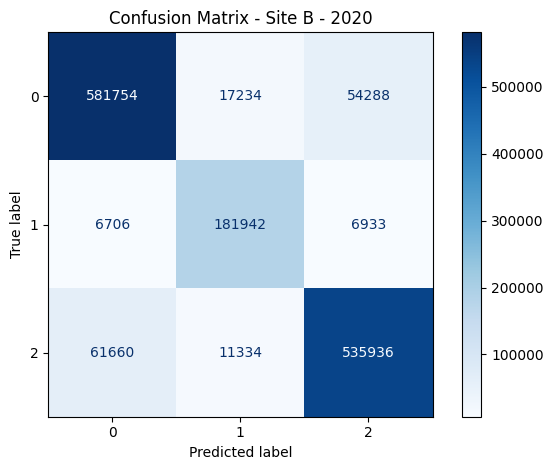


Training with 30000 samples...


Training Epoch 1: 100%|██████████| 469/469 [00:10<00:00, 44.18it/s]


Loss: 0.2025 + 1e-08 * 2835250.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.42it/s]


Epoch [1/15] Train Loss: 0.3926, Train Acc: 0.8609 | Val Loss: 0.3139, Val Acc: 0.8861


Training Epoch 2: 100%|██████████| 469/469 [00:10<00:00, 44.21it/s]


Loss: 0.1746 + 1e-08 * 2776242.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.91it/s]


Epoch [2/15] Train Loss: 0.2985, Train Acc: 0.8930 | Val Loss: 0.2895, Val Acc: 0.8991


Training Epoch 3: 100%|██████████| 469/469 [00:10<00:00, 43.92it/s]


Loss: 0.0903 + 1e-08 * 2722022.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.36it/s]


Epoch [3/15] Train Loss: 0.2788, Train Acc: 0.9027 | Val Loss: 0.2806, Val Acc: 0.9012


Training Epoch 4: 100%|██████████| 469/469 [00:10<00:00, 44.15it/s]


Loss: 0.2326 + 1e-08 * 2675769.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.13it/s]


Epoch [4/15] Train Loss: 0.2643, Train Acc: 0.9095 | Val Loss: 0.2827, Val Acc: 0.8982


Training Epoch 5: 100%|██████████| 469/469 [00:10<00:00, 44.25it/s]


Loss: 0.2162 + 1e-08 * 2638549.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.70it/s]


Epoch [5/15] Train Loss: 0.2530, Train Acc: 0.9101 | Val Loss: 0.2776, Val Acc: 0.9002


Training Epoch 6: 100%|██████████| 469/469 [00:10<00:00, 43.10it/s]


Loss: 0.1817 + 1e-08 * 2602205.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.34it/s]


Epoch [6/15] Train Loss: 0.2418, Train Acc: 0.9145 | Val Loss: 0.2745, Val Acc: 0.9031


Training Epoch 7: 100%|██████████| 469/469 [00:10<00:00, 43.73it/s]


Loss: 0.2385 + 1e-08 * 2580295.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 142.05it/s]


Epoch [7/15] Train Loss: 0.2325, Train Acc: 0.9186 | Val Loss: 0.2706, Val Acc: 0.9038


Training Epoch 8: 100%|██████████| 469/469 [00:10<00:00, 44.04it/s]


Loss: 0.2054 + 1e-08 * 2565791.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.84it/s]


Epoch [8/15] Train Loss: 0.2259, Train Acc: 0.9221 | Val Loss: 0.2768, Val Acc: 0.9019


Training Epoch 9: 100%|██████████| 469/469 [00:10<00:00, 44.08it/s]


Loss: 0.0562 + 1e-08 * 2556585.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.37it/s]


Epoch [9/15] Train Loss: 0.2181, Train Acc: 0.9240 | Val Loss: 0.2758, Val Acc: 0.9017


Training Epoch 10: 100%|██████████| 469/469 [00:10<00:00, 44.10it/s]


Loss: 0.2714 + 1e-08 * 2552682.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.25it/s]


Epoch [10/15] Train Loss: 0.2100, Train Acc: 0.9257 | Val Loss: 0.2841, Val Acc: 0.9028


Training Epoch 11: 100%|██████████| 469/469 [00:10<00:00, 43.97it/s]


Loss: 0.4146 + 1e-08 * 2554200.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.74it/s]


Epoch [11/15] Train Loss: 0.2001, Train Acc: 0.9318 | Val Loss: 0.2870, Val Acc: 0.8999


Training Epoch 12: 100%|██████████| 469/469 [00:10<00:00, 43.70it/s]


Loss: 0.0914 + 1e-08 * 2559139.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.10it/s]


Epoch [12/15] Train Loss: 0.1931, Train Acc: 0.9337 | Val Loss: 0.2861, Val Acc: 0.9038


Training Epoch 13: 100%|██████████| 469/469 [00:10<00:00, 44.04it/s]


Loss: 0.2153 + 1e-08 * 2570686.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.31it/s]


Epoch [13/15] Train Loss: 0.1864, Train Acc: 0.9360 | Val Loss: 0.2902, Val Acc: 0.8989


Training Epoch 14: 100%|██████████| 469/469 [00:10<00:00, 44.08it/s]


Loss: 0.2242 + 1e-08 * 2579205.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.56it/s]


Epoch [14/15] Train Loss: 0.1766, Train Acc: 0.9387 | Val Loss: 0.3016, Val Acc: 0.8997


Training Epoch 15: 100%|██████████| 469/469 [00:10<00:00, 44.11it/s]


Loss: 0.0599 + 1e-08 * 2591995.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.00it/s]


Epoch [15/15] Train Loss: 0.1713, Train Acc: 0.9417 | Val Loss: 0.3005, Val Acc: 0.8998


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 142.07it/s]


Stochastic Accuracy (mean over T): 0.9004
Cohen's Kappa: 0.8358
Per-class F1: [0.8997853  0.91100948 0.89770304]
Average F1 (macro): 0.9028


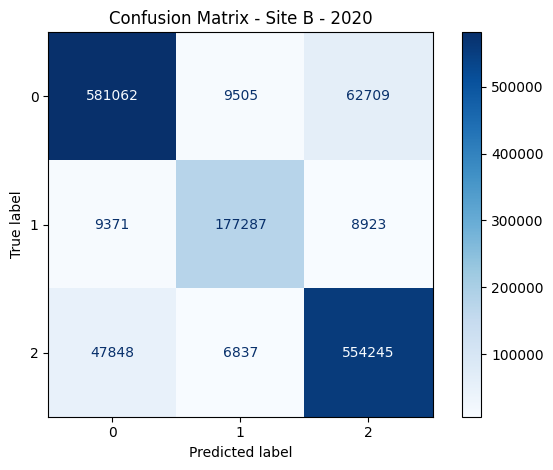


Training with 45000 samples...


Training Epoch 1: 100%|██████████| 704/704 [00:15<00:00, 44.24it/s]


Loss: 0.2299 + 1e-08 * 2812300.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.26it/s]


Epoch [1/15] Train Loss: 0.3673, Train Acc: 0.8686 | Val Loss: 0.2888, Val Acc: 0.8972


Training Epoch 2: 100%|██████████| 704/704 [00:15<00:00, 44.19it/s]


Loss: 1.3768 + 1e-08 * 2726435.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [2/15] Train Loss: 0.2859, Train Acc: 0.9000 | Val Loss: 0.2764, Val Acc: 0.9022


Training Epoch 3: 100%|██████████| 704/704 [00:15<00:00, 44.17it/s]


Loss: 0.1003 + 1e-08 * 2653694.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.21it/s]


Epoch [3/15] Train Loss: 0.2675, Train Acc: 0.9059 | Val Loss: 0.2786, Val Acc: 0.9028


Training Epoch 4: 100%|██████████| 704/704 [00:15<00:00, 44.09it/s]


Loss: 1.1398 + 1e-08 * 2590100.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.52it/s]


Epoch [4/15] Train Loss: 0.2562, Train Acc: 0.9089 | Val Loss: 0.2662, Val Acc: 0.9059


Training Epoch 5: 100%|██████████| 704/704 [00:15<00:00, 44.06it/s]


Loss: 0.1051 + 1e-08 * 2540870.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.79it/s]


Epoch [5/15] Train Loss: 0.2481, Train Acc: 0.9128 | Val Loss: 0.2631, Val Acc: 0.9056


Training Epoch 6: 100%|██████████| 704/704 [00:15<00:00, 44.07it/s]


Loss: 0.0640 + 1e-08 * 2500588.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.54it/s]


Epoch [6/15] Train Loss: 0.2381, Train Acc: 0.9162 | Val Loss: 0.2611, Val Acc: 0.9071


Training Epoch 7: 100%|██████████| 704/704 [00:15<00:00, 44.09it/s]


Loss: 0.1747 + 1e-08 * 2469754.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.28it/s]


Epoch [7/15] Train Loss: 0.2299, Train Acc: 0.9174 | Val Loss: 0.2731, Val Acc: 0.9025


Training Epoch 8: 100%|██████████| 704/704 [00:15<00:00, 44.02it/s]


Loss: 0.0505 + 1e-08 * 2451045.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.09it/s]


Epoch [8/15] Train Loss: 0.2222, Train Acc: 0.9208 | Val Loss: 0.2642, Val Acc: 0.9055


Training Epoch 9: 100%|██████████| 704/704 [00:16<00:00, 43.96it/s]


Loss: 0.3772 + 1e-08 * 2441616.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.77it/s]


Epoch [9/15] Train Loss: 0.2148, Train Acc: 0.9238 | Val Loss: 0.2704, Val Acc: 0.9061


Training Epoch 10: 100%|██████████| 704/704 [00:15<00:00, 44.08it/s]


Loss: 0.1256 + 1e-08 * 2436579.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [10/15] Train Loss: 0.2062, Train Acc: 0.9280 | Val Loss: 0.2666, Val Acc: 0.9065


Training Epoch 11: 100%|██████████| 704/704 [00:15<00:00, 44.02it/s]


Loss: 0.0154 + 1e-08 * 2440267.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.29it/s]


Epoch [11/15] Train Loss: 0.2017, Train Acc: 0.9286 | Val Loss: 0.2749, Val Acc: 0.9051


Training Epoch 12: 100%|██████████| 704/704 [00:15<00:00, 44.01it/s]


Loss: 0.2716 + 1e-08 * 2445536.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.95it/s]


Epoch [12/15] Train Loss: 0.1944, Train Acc: 0.9322 | Val Loss: 0.2747, Val Acc: 0.9043


Training Epoch 13: 100%|██████████| 704/704 [00:16<00:00, 43.81it/s]


Loss: 0.1152 + 1e-08 * 2456107.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.53it/s]


Epoch [13/15] Train Loss: 0.1849, Train Acc: 0.9352 | Val Loss: 0.2842, Val Acc: 0.9038


Training Epoch 14: 100%|██████████| 704/704 [00:16<00:00, 43.07it/s]


Loss: 0.5341 + 1e-08 * 2471126.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 140.44it/s]


Epoch [14/15] Train Loss: 0.1825, Train Acc: 0.9367 | Val Loss: 0.2843, Val Acc: 0.9036


Training Epoch 15: 100%|██████████| 704/704 [00:16<00:00, 43.40it/s]


Loss: 0.1250 + 1e-08 * 2485806.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.64it/s]


Epoch [15/15] Train Loss: 0.1751, Train Acc: 0.9397 | Val Loss: 0.2876, Val Acc: 0.9037


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:42<00:00, 140.32it/s]


Stochastic Accuracy (mean over T): 0.9035
Cohen's Kappa: 0.8409
Per-class F1: [0.90245025 0.91617801 0.90053852]
Average F1 (macro): 0.9064


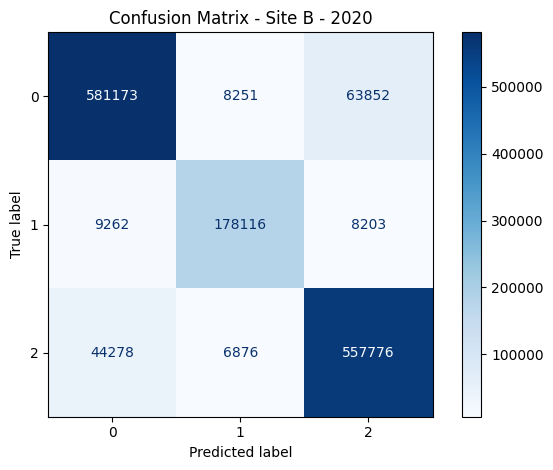


Training with 60000 samples...


Training Epoch 1: 100%|██████████| 938/938 [00:21<00:00, 43.68it/s]


Loss: 0.2352 + 1e-08 * 2779926.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.61it/s]


Epoch [1/15] Train Loss: 0.3488, Train Acc: 0.8757 | Val Loss: 0.2822, Val Acc: 0.9007


Training Epoch 2: 100%|██████████| 938/938 [00:21<00:00, 44.05it/s]


Loss: 0.4439 + 1e-08 * 2661883.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.81it/s]


Epoch [2/15] Train Loss: 0.2773, Train Acc: 0.9023 | Val Loss: 0.2681, Val Acc: 0.9032


Training Epoch 3: 100%|██████████| 938/938 [00:21<00:00, 43.80it/s]


Loss: 0.2757 + 1e-08 * 2562457.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [3/15] Train Loss: 0.2600, Train Acc: 0.9081 | Val Loss: 0.2664, Val Acc: 0.9038


Training Epoch 4: 100%|██████████| 938/938 [00:21<00:00, 43.93it/s]


Loss: 0.2740 + 1e-08 * 2482638.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.78it/s]


Epoch [4/15] Train Loss: 0.2500, Train Acc: 0.9112 | Val Loss: 0.2609, Val Acc: 0.9055


Training Epoch 5: 100%|██████████| 938/938 [00:21<00:00, 44.15it/s]


Loss: 0.1972 + 1e-08 * 2423997.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.52it/s]


Epoch [5/15] Train Loss: 0.2416, Train Acc: 0.9139 | Val Loss: 0.2580, Val Acc: 0.9087


Training Epoch 6: 100%|██████████| 938/938 [00:21<00:00, 44.11it/s]


Loss: 0.2802 + 1e-08 * 2384863.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.09it/s]


Epoch [6/15] Train Loss: 0.2337, Train Acc: 0.9163 | Val Loss: 0.2570, Val Acc: 0.9086


Training Epoch 7: 100%|██████████| 938/938 [00:21<00:00, 43.87it/s]


Loss: 0.3885 + 1e-08 * 2352820.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [7/15] Train Loss: 0.2250, Train Acc: 0.9201 | Val Loss: 0.2533, Val Acc: 0.9097


Training Epoch 8: 100%|██████████| 938/938 [00:21<00:00, 43.84it/s]


Loss: 0.2983 + 1e-08 * 2331386.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.42it/s]


Epoch [8/15] Train Loss: 0.2192, Train Acc: 0.9222 | Val Loss: 0.2629, Val Acc: 0.9039


Training Epoch 9: 100%|██████████| 938/938 [00:21<00:00, 43.82it/s]


Loss: 0.1495 + 1e-08 * 2323832.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.95it/s]


Epoch [9/15] Train Loss: 0.2107, Train Acc: 0.9251 | Val Loss: 0.2642, Val Acc: 0.9040


Training Epoch 10: 100%|██████████| 938/938 [00:21<00:00, 43.89it/s]


Loss: 0.1360 + 1e-08 * 2316283.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.47it/s]


Epoch [10/15] Train Loss: 0.2053, Train Acc: 0.9282 | Val Loss: 0.2566, Val Acc: 0.9079


Training Epoch 11: 100%|██████████| 938/938 [00:21<00:00, 43.93it/s]


Loss: 0.3587 + 1e-08 * 2318447.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.03it/s]


Epoch [11/15] Train Loss: 0.1995, Train Acc: 0.9295 | Val Loss: 0.2656, Val Acc: 0.9057


Training Epoch 12: 100%|██████████| 938/938 [00:21<00:00, 43.74it/s]


Loss: 0.4246 + 1e-08 * 2326348.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.31it/s]


Epoch [12/15] Train Loss: 0.1924, Train Acc: 0.9319 | Val Loss: 0.2651, Val Acc: 0.9085


Training Epoch 13: 100%|██████████| 938/938 [00:21<00:00, 44.13it/s]


Loss: 0.1486 + 1e-08 * 2340170.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.21it/s]


Epoch [13/15] Train Loss: 0.1869, Train Acc: 0.9345 | Val Loss: 0.2709, Val Acc: 0.9039


Training Epoch 14: 100%|██████████| 938/938 [00:21<00:00, 44.23it/s]


Loss: 0.1381 + 1e-08 * 2353673.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.80it/s]


Epoch [14/15] Train Loss: 0.1784, Train Acc: 0.9367 | Val Loss: 0.2725, Val Acc: 0.9059


Training Epoch 15: 100%|██████████| 938/938 [00:21<00:00, 44.12it/s]


Loss: 0.1435 + 1e-08 * 2376308.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.35it/s]


Epoch [15/15] Train Loss: 0.1745, Train Acc: 0.9382 | Val Loss: 0.2767, Val Acc: 0.9030


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 142.24it/s]


Stochastic Accuracy (mean over T): 0.9034
Cohen's Kappa: 0.8413
Per-class F1: [0.90550642 0.90627966 0.9002141 ]
Average F1 (macro): 0.9040


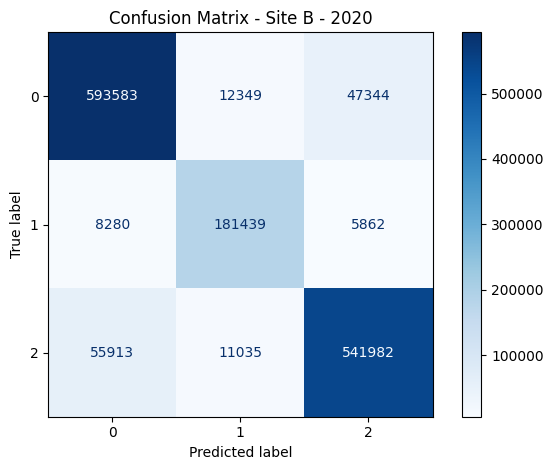


Training with 75000 samples...


Training Epoch 1: 100%|██████████| 1172/1172 [00:26<00:00, 44.21it/s]


Loss: 0.2218 + 1e-08 * 2742802.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.18it/s]


Epoch [1/15] Train Loss: 0.3366, Train Acc: 0.8794 | Val Loss: 0.2821, Val Acc: 0.8981


Training Epoch 2: 100%|██████████| 1172/1172 [00:26<00:00, 44.08it/s]


Loss: 0.1577 + 1e-08 * 2596770.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.09it/s]


Epoch [2/15] Train Loss: 0.2717, Train Acc: 0.9044 | Val Loss: 0.2711, Val Acc: 0.9054


Training Epoch 3: 100%|██████████| 1172/1172 [00:26<00:00, 44.09it/s]


Loss: 0.1298 + 1e-08 * 2482816.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.91it/s]


Epoch [3/15] Train Loss: 0.2579, Train Acc: 0.9088 | Val Loss: 0.2577, Val Acc: 0.9084


Training Epoch 4: 100%|██████████| 1172/1172 [00:26<00:00, 44.07it/s]


Loss: 0.1948 + 1e-08 * 2396886.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.31it/s]


Epoch [4/15] Train Loss: 0.2466, Train Acc: 0.9125 | Val Loss: 0.2582, Val Acc: 0.9071


Training Epoch 5: 100%|██████████| 1172/1172 [00:26<00:00, 44.07it/s]


Loss: 0.1546 + 1e-08 * 2332716.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.47it/s]


Epoch [5/15] Train Loss: 0.2385, Train Acc: 0.9140 | Val Loss: 0.2551, Val Acc: 0.9104


Training Epoch 6: 100%|██████████| 1172/1172 [00:26<00:00, 44.10it/s]


Loss: 0.2173 + 1e-08 * 2282358.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.03it/s]


Epoch [6/15] Train Loss: 0.2300, Train Acc: 0.9171 | Val Loss: 0.2481, Val Acc: 0.9107


Training Epoch 7: 100%|██████████| 1172/1172 [00:26<00:00, 44.12it/s]


Loss: 0.1396 + 1e-08 * 2249232.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.92it/s]


Epoch [7/15] Train Loss: 0.2228, Train Acc: 0.9203 | Val Loss: 0.2692, Val Acc: 0.9009


Training Epoch 8: 100%|██████████| 1172/1172 [00:26<00:00, 44.08it/s]


Loss: 0.1807 + 1e-08 * 2228252.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.41it/s]


Epoch [8/15] Train Loss: 0.2168, Train Acc: 0.9222 | Val Loss: 0.2511, Val Acc: 0.9114


Training Epoch 9: 100%|██████████| 1172/1172 [00:26<00:00, 44.09it/s]


Loss: 0.1071 + 1e-08 * 2216125.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.52it/s]


Epoch [9/15] Train Loss: 0.2117, Train Acc: 0.9238 | Val Loss: 0.2497, Val Acc: 0.9108


Training Epoch 10: 100%|██████████| 1172/1172 [00:26<00:00, 44.07it/s]


Loss: 0.1766 + 1e-08 * 2216428.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.32it/s]


Epoch [10/15] Train Loss: 0.2070, Train Acc: 0.9259 | Val Loss: 0.2543, Val Acc: 0.9087


Training Epoch 11: 100%|██████████| 1172/1172 [00:26<00:00, 44.17it/s]


Loss: 0.1443 + 1e-08 * 2214928.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.62it/s]


Epoch [11/15] Train Loss: 0.2001, Train Acc: 0.9292 | Val Loss: 0.2544, Val Acc: 0.9083


Training Epoch 12: 100%|██████████| 1172/1172 [00:26<00:00, 44.05it/s]


Loss: 0.2240 + 1e-08 * 2225257.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.97it/s]


Epoch [12/15] Train Loss: 0.1957, Train Acc: 0.9306 | Val Loss: 0.2604, Val Acc: 0.9058


Training Epoch 13: 100%|██████████| 1172/1172 [00:26<00:00, 43.97it/s]


Loss: 0.0644 + 1e-08 * 2236003.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.01it/s]


Epoch [13/15] Train Loss: 0.1906, Train Acc: 0.9325 | Val Loss: 0.2625, Val Acc: 0.9075


Training Epoch 14: 100%|██████████| 1172/1172 [00:26<00:00, 44.11it/s]


Loss: 0.2114 + 1e-08 * 2254365.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.10it/s]


Epoch [14/15] Train Loss: 0.1851, Train Acc: 0.9348 | Val Loss: 0.2651, Val Acc: 0.9094


Training Epoch 15: 100%|██████████| 1172/1172 [00:26<00:00, 44.06it/s]


Loss: 0.2412 + 1e-08 * 2278235.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.52it/s]


Epoch [15/15] Train Loss: 0.1805, Train Acc: 0.9363 | Val Loss: 0.2656, Val Acc: 0.9096


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 141.51it/s]


Stochastic Accuracy (mean over T): 0.9099
Cohen's Kappa: 0.8515
Per-class F1: [0.91007897 0.92120323 0.90617501]
Average F1 (macro): 0.9125


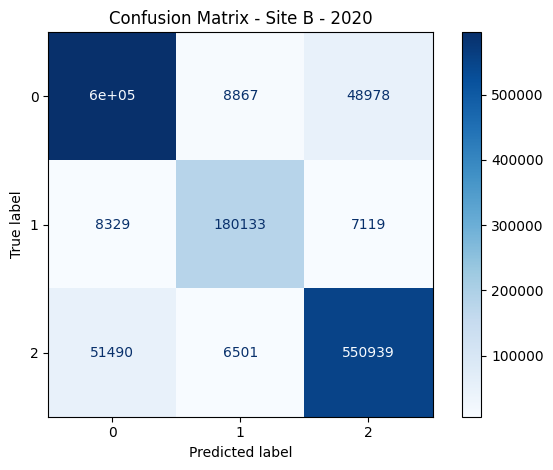


Training with 90000 samples...


Training Epoch 1: 100%|██████████| 1407/1407 [00:32<00:00, 43.87it/s]


Loss: 0.1743 + 1e-08 * 2715394.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.69it/s]


Epoch [1/15] Train Loss: 0.3251, Train Acc: 0.8840 | Val Loss: 0.2738, Val Acc: 0.9033


Training Epoch 2: 100%|██████████| 1407/1407 [00:31<00:00, 44.04it/s]


Loss: 0.3512 + 1e-08 * 2549817.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.28it/s]


Epoch [2/15] Train Loss: 0.2672, Train Acc: 0.9055 | Val Loss: 0.2610, Val Acc: 0.9074


Training Epoch 3: 100%|██████████| 1407/1407 [00:31<00:00, 44.16it/s]


Loss: 0.2550 + 1e-08 * 2421390.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.27it/s]


Epoch [3/15] Train Loss: 0.2523, Train Acc: 0.9095 | Val Loss: 0.2549, Val Acc: 0.9086


Training Epoch 4: 100%|██████████| 1407/1407 [00:31<00:00, 44.09it/s]


Loss: 0.0820 + 1e-08 * 2322621.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.82it/s]


Epoch [4/15] Train Loss: 0.2421, Train Acc: 0.9136 | Val Loss: 0.2571, Val Acc: 0.9057


Training Epoch 5: 100%|██████████| 1407/1407 [00:31<00:00, 44.16it/s]


Loss: 0.1185 + 1e-08 * 2253028.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.75it/s]


Epoch [5/15] Train Loss: 0.2343, Train Acc: 0.9152 | Val Loss: 0.2482, Val Acc: 0.9108


Training Epoch 6: 100%|██████████| 1407/1407 [00:31<00:00, 44.07it/s]


Loss: 0.0355 + 1e-08 * 2206370.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.11it/s]


Epoch [6/15] Train Loss: 0.2268, Train Acc: 0.9174 | Val Loss: 0.2490, Val Acc: 0.9087


Training Epoch 7: 100%|██████████| 1407/1407 [00:31<00:00, 44.13it/s]


Loss: 0.0679 + 1e-08 * 2176131.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.86it/s]


Epoch [7/15] Train Loss: 0.2215, Train Acc: 0.9201 | Val Loss: 0.2465, Val Acc: 0.9117


Training Epoch 8: 100%|██████████| 1407/1407 [00:32<00:00, 43.88it/s]


Loss: 0.0261 + 1e-08 * 2154381.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.51it/s]


Epoch [8/15] Train Loss: 0.2153, Train Acc: 0.9226 | Val Loss: 0.2581, Val Acc: 0.9070


Training Epoch 9: 100%|██████████| 1407/1407 [00:32<00:00, 43.86it/s]


Loss: 0.1591 + 1e-08 * 2142595.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.07it/s]


Epoch [9/15] Train Loss: 0.2089, Train Acc: 0.9252 | Val Loss: 0.2521, Val Acc: 0.9097


Training Epoch 10: 100%|██████████| 1407/1407 [00:31<00:00, 43.98it/s]


Loss: 0.3256 + 1e-08 * 2138337.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.88it/s]


Epoch [10/15] Train Loss: 0.2043, Train Acc: 0.9256 | Val Loss: 0.2506, Val Acc: 0.9103


Training Epoch 11: 100%|██████████| 1407/1407 [00:31<00:00, 44.04it/s]


Loss: 0.0487 + 1e-08 * 2144240.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.70it/s]


Epoch [11/15] Train Loss: 0.1986, Train Acc: 0.9287 | Val Loss: 0.2531, Val Acc: 0.9102


Training Epoch 12: 100%|██████████| 1407/1407 [00:32<00:00, 43.85it/s]


Loss: 0.0949 + 1e-08 * 2154009.5


Validation: 100%|██████████| 1519/1519 [00:11<00:00, 137.77it/s]


Epoch [12/15] Train Loss: 0.1952, Train Acc: 0.9300 | Val Loss: 0.2540, Val Acc: 0.9093


Training Epoch 13: 100%|██████████| 1407/1407 [00:32<00:00, 43.69it/s]


Loss: 0.0867 + 1e-08 * 2166940.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [13/15] Train Loss: 0.1886, Train Acc: 0.9326 | Val Loss: 0.2508, Val Acc: 0.9103


Training Epoch 14: 100%|██████████| 1407/1407 [00:32<00:00, 43.72it/s]


Loss: 0.0745 + 1e-08 * 2185746.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.52it/s]


Epoch [14/15] Train Loss: 0.1850, Train Acc: 0.9338 | Val Loss: 0.2549, Val Acc: 0.9092


Training Epoch 15: 100%|██████████| 1407/1407 [00:32<00:00, 43.73it/s]


Loss: 0.2971 + 1e-08 * 2208281.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.75it/s]


Epoch [15/15] Train Loss: 0.1787, Train Acc: 0.9369 | Val Loss: 0.2625, Val Acc: 0.9077


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 141.89it/s]


Stochastic Accuracy (mean over T): 0.9077
Cohen's Kappa: 0.8488
Per-class F1: [0.90870592 0.90659199 0.9071117 ]
Average F1 (macro): 0.9075


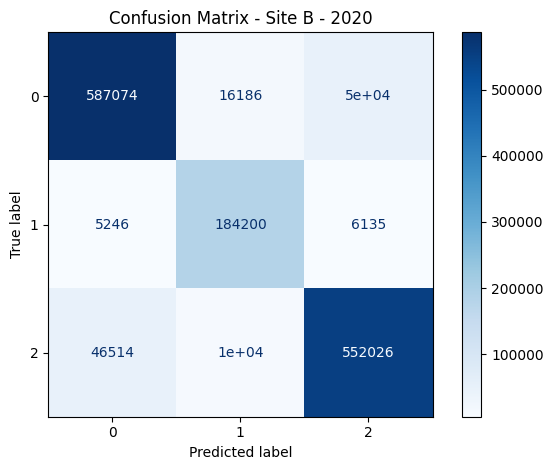


Training with 105000 samples...


Training Epoch 1: 100%|██████████| 1641/1641 [00:37<00:00, 44.03it/s]


Loss: 0.2394 + 1e-08 * 2679254.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.72it/s]


Epoch [1/15] Train Loss: 0.3184, Train Acc: 0.8869 | Val Loss: 0.2744, Val Acc: 0.9034


Training Epoch 2: 100%|██████████| 1641/1641 [00:37<00:00, 44.21it/s]


Loss: 0.2020 + 1e-08 * 2496469.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.95it/s]


Epoch [2/15] Train Loss: 0.2638, Train Acc: 0.9062 | Val Loss: 0.2588, Val Acc: 0.9085


Training Epoch 3: 100%|██████████| 1641/1641 [00:37<00:00, 44.02it/s]


Loss: 0.2756 + 1e-08 * 2362175.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.96it/s]


Epoch [3/15] Train Loss: 0.2503, Train Acc: 0.9102 | Val Loss: 0.2524, Val Acc: 0.9108


Training Epoch 4: 100%|██████████| 1641/1641 [00:37<00:00, 43.76it/s]


Loss: 0.1440 + 1e-08 * 2262936.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.06it/s]


Epoch [4/15] Train Loss: 0.2397, Train Acc: 0.9140 | Val Loss: 0.2465, Val Acc: 0.9104


Training Epoch 5: 100%|██████████| 1641/1641 [00:37<00:00, 43.98it/s]


Loss: 0.1541 + 1e-08 * 2195725.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.38it/s]


Epoch [5/15] Train Loss: 0.2313, Train Acc: 0.9164 | Val Loss: 0.2539, Val Acc: 0.9100


Training Epoch 6: 100%|██████████| 1641/1641 [00:37<00:00, 43.94it/s]


Loss: 0.1678 + 1e-08 * 2150182.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.61it/s]


Epoch [6/15] Train Loss: 0.2252, Train Acc: 0.9187 | Val Loss: 0.2488, Val Acc: 0.9096


Training Epoch 7: 100%|██████████| 1641/1641 [00:37<00:00, 44.09it/s]


Loss: 0.2381 + 1e-08 * 2113960.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.77it/s]


Epoch [7/15] Train Loss: 0.2192, Train Acc: 0.9216 | Val Loss: 0.2444, Val Acc: 0.9131


Training Epoch 8: 100%|██████████| 1641/1641 [00:37<00:00, 44.12it/s]


Loss: 0.2154 + 1e-08 * 2093995.125


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.10it/s]


Epoch [8/15] Train Loss: 0.2137, Train Acc: 0.9234 | Val Loss: 0.2452, Val Acc: 0.9119


Training Epoch 9: 100%|██████████| 1641/1641 [00:37<00:00, 44.07it/s]


Loss: 0.1774 + 1e-08 * 2090392.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.79it/s]


Epoch [9/15] Train Loss: 0.2094, Train Acc: 0.9241 | Val Loss: 0.2462, Val Acc: 0.9124


Training Epoch 10: 100%|██████████| 1641/1641 [00:37<00:00, 43.75it/s]


Loss: 0.1875 + 1e-08 * 2089049.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.31it/s]


Epoch [10/15] Train Loss: 0.2035, Train Acc: 0.9266 | Val Loss: 0.2478, Val Acc: 0.9118


Training Epoch 11: 100%|██████████| 1641/1641 [00:37<00:00, 43.66it/s]


Loss: 0.2818 + 1e-08 * 2092557.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.63it/s]


Epoch [11/15] Train Loss: 0.1992, Train Acc: 0.9285 | Val Loss: 0.2535, Val Acc: 0.9094


Training Epoch 12: 100%|██████████| 1641/1641 [00:37<00:00, 43.76it/s]


Loss: 0.2021 + 1e-08 * 2108495.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.83it/s]


Epoch [12/15] Train Loss: 0.1932, Train Acc: 0.9304 | Val Loss: 0.2478, Val Acc: 0.9105


Training Epoch 13: 100%|██████████| 1641/1641 [00:37<00:00, 43.96it/s]


Loss: 0.0547 + 1e-08 * 2123612.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.38it/s]


Epoch [13/15] Train Loss: 0.1895, Train Acc: 0.9320 | Val Loss: 0.2532, Val Acc: 0.9117


Training Epoch 14: 100%|██████████| 1641/1641 [00:37<00:00, 44.05it/s]


Loss: 0.1950 + 1e-08 * 2144340.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.32it/s]


Epoch [14/15] Train Loss: 0.1848, Train Acc: 0.9342 | Val Loss: 0.2587, Val Acc: 0.9100


Training Epoch 15: 100%|██████████| 1641/1641 [00:37<00:00, 44.01it/s]


Loss: 0.2549 + 1e-08 * 2170702.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.74it/s]


Epoch [15/15] Train Loss: 0.1806, Train Acc: 0.9357 | Val Loss: 0.2538, Val Acc: 0.9122


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:40<00:00, 142.05it/s]


Stochastic Accuracy (mean over T): 0.9128
Cohen's Kappa: 0.8561
Per-class F1: [0.9129058  0.92516295 0.90881343]
Average F1 (macro): 0.9156


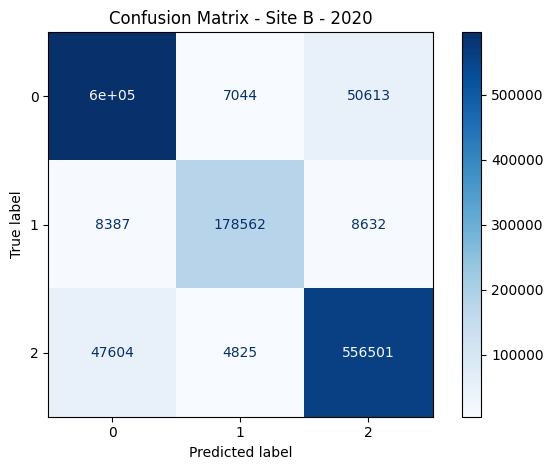


Training with 120000 samples...


Training Epoch 1: 100%|██████████| 1875/1875 [00:42<00:00, 44.07it/s]


Loss: 0.1669 + 1e-08 * 2651945.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.47it/s]


Epoch [1/15] Train Loss: 0.3151, Train Acc: 0.8875 | Val Loss: 0.2730, Val Acc: 0.9017


Training Epoch 2: 100%|██████████| 1875/1875 [00:42<00:00, 44.08it/s]


Loss: 0.2384 + 1e-08 * 2451364.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.08it/s]


Epoch [2/15] Train Loss: 0.2634, Train Acc: 0.9060 | Val Loss: 0.2614, Val Acc: 0.9063


Training Epoch 3: 100%|██████████| 1875/1875 [00:42<00:00, 44.04it/s]


Loss: 0.3246 + 1e-08 * 2306547.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.47it/s]


Epoch [3/15] Train Loss: 0.2482, Train Acc: 0.9111 | Val Loss: 0.2516, Val Acc: 0.9088


Training Epoch 4: 100%|██████████| 1875/1875 [00:42<00:00, 44.02it/s]


Loss: 0.1386 + 1e-08 * 2197730.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.95it/s]


Epoch [4/15] Train Loss: 0.2386, Train Acc: 0.9141 | Val Loss: 0.2481, Val Acc: 0.9104


Training Epoch 5: 100%|██████████| 1875/1875 [00:42<00:00, 44.02it/s]


Loss: 0.2344 + 1e-08 * 2121399.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.65it/s]


Epoch [5/15] Train Loss: 0.2303, Train Acc: 0.9170 | Val Loss: 0.2441, Val Acc: 0.9117


Training Epoch 6: 100%|██████████| 1875/1875 [00:42<00:00, 43.99it/s]


Loss: 0.1550 + 1e-08 * 2074354.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.09it/s]


Epoch [6/15] Train Loss: 0.2235, Train Acc: 0.9193 | Val Loss: 0.2388, Val Acc: 0.9142


Training Epoch 7: 100%|██████████| 1875/1875 [00:42<00:00, 43.93it/s]


Loss: 0.1369 + 1e-08 * 2036900.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [7/15] Train Loss: 0.2183, Train Acc: 0.9215 | Val Loss: 0.2391, Val Acc: 0.9129


Training Epoch 8: 100%|██████████| 1875/1875 [00:42<00:00, 43.90it/s]


Loss: 0.2147 + 1e-08 * 2021957.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.64it/s]


Epoch [8/15] Train Loss: 0.2132, Train Acc: 0.9220 | Val Loss: 0.2373, Val Acc: 0.9147


Training Epoch 9: 100%|██████████| 1875/1875 [00:42<00:00, 43.72it/s]


Loss: 0.1699 + 1e-08 * 2011953.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.86it/s]


Epoch [9/15] Train Loss: 0.2083, Train Acc: 0.9246 | Val Loss: 0.2446, Val Acc: 0.9120


Training Epoch 10: 100%|██████████| 1875/1875 [00:42<00:00, 43.93it/s]


Loss: 0.3474 + 1e-08 * 2013278.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.19it/s]


Epoch [10/15] Train Loss: 0.2032, Train Acc: 0.9257 | Val Loss: 0.2485, Val Acc: 0.9107


Training Epoch 11: 100%|██████████| 1875/1875 [00:42<00:00, 43.77it/s]


Loss: 0.1319 + 1e-08 * 2015107.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.74it/s]


Epoch [11/15] Train Loss: 0.2002, Train Acc: 0.9272 | Val Loss: 0.2421, Val Acc: 0.9132


Training Epoch 12: 100%|██████████| 1875/1875 [00:42<00:00, 44.05it/s]


Loss: 0.2735 + 1e-08 * 2024878.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.31it/s]


Epoch [12/15] Train Loss: 0.1962, Train Acc: 0.9296 | Val Loss: 0.2411, Val Acc: 0.9144


Training Epoch 13: 100%|██████████| 1875/1875 [00:42<00:00, 44.04it/s]


Loss: 0.1985 + 1e-08 * 2041197.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.06it/s]


Epoch [13/15] Train Loss: 0.1905, Train Acc: 0.9310 | Val Loss: 0.2463, Val Acc: 0.9124


Training Epoch 14: 100%|██████████| 1875/1875 [00:42<00:00, 44.00it/s]


Loss: 0.2345 + 1e-08 * 2063671.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.20it/s]


Epoch [14/15] Train Loss: 0.1866, Train Acc: 0.9330 | Val Loss: 0.2465, Val Acc: 0.9131


Training Epoch 15: 100%|██████████| 1875/1875 [00:42<00:00, 43.87it/s]


Loss: 0.2141 + 1e-08 * 2088255.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.74it/s]


Epoch [15/15] Train Loss: 0.1823, Train Acc: 0.9348 | Val Loss: 0.2574, Val Acc: 0.9103


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.47it/s]


Stochastic Accuracy (mean over T): 0.9092
Cohen's Kappa: 0.8501
Per-class F1: [0.91129023 0.92138275 0.90286243]
Average F1 (macro): 0.9118


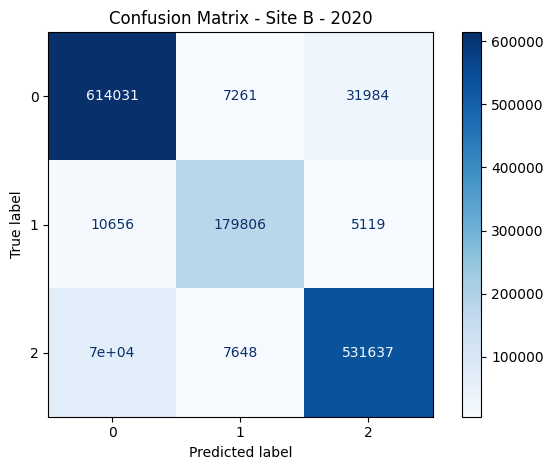


Training with 135000 samples...


Training Epoch 1: 100%|██████████| 2110/2110 [00:48<00:00, 43.88it/s]


Loss: 0.1709 + 1e-08 * 2623283.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.79it/s]


Epoch [1/15] Train Loss: 0.3086, Train Acc: 0.8897 | Val Loss: 0.2691, Val Acc: 0.9050


Training Epoch 2: 100%|██████████| 2110/2110 [00:48<00:00, 43.85it/s]


Loss: 0.5118 + 1e-08 * 2398760.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.06it/s]


Epoch [2/15] Train Loss: 0.2608, Train Acc: 0.9070 | Val Loss: 0.2539, Val Acc: 0.9110


Training Epoch 3: 100%|██████████| 2110/2110 [00:47<00:00, 44.06it/s]


Loss: 0.0366 + 1e-08 * 2244584.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.91it/s]


Epoch [3/15] Train Loss: 0.2463, Train Acc: 0.9117 | Val Loss: 0.2480, Val Acc: 0.9111


Training Epoch 4: 100%|██████████| 2110/2110 [00:47<00:00, 44.11it/s]


Loss: 0.0371 + 1e-08 * 2141154.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.87it/s]


Epoch [4/15] Train Loss: 0.2363, Train Acc: 0.9149 | Val Loss: 0.2475, Val Acc: 0.9094


Training Epoch 5: 100%|██████████| 2110/2110 [00:47<00:00, 44.12it/s]


Loss: 0.1813 + 1e-08 * 2066681.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.79it/s]


Epoch [5/15] Train Loss: 0.2285, Train Acc: 0.9175 | Val Loss: 0.2406, Val Acc: 0.9146


Training Epoch 6: 100%|██████████| 2110/2110 [00:47<00:00, 44.13it/s]


Loss: 0.2007 + 1e-08 * 2014197.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [6/15] Train Loss: 0.2230, Train Acc: 0.9197 | Val Loss: 0.2417, Val Acc: 0.9103


Training Epoch 7: 100%|██████████| 2110/2110 [00:47<00:00, 44.10it/s]


Loss: 0.1657 + 1e-08 * 1985946.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.41it/s]


Epoch [7/15] Train Loss: 0.2174, Train Acc: 0.9209 | Val Loss: 0.2399, Val Acc: 0.9131


Training Epoch 8: 100%|██████████| 2110/2110 [00:47<00:00, 44.08it/s]


Loss: 0.1527 + 1e-08 * 1967777.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.34it/s]


Epoch [8/15] Train Loss: 0.2129, Train Acc: 0.9221 | Val Loss: 0.2381, Val Acc: 0.9147


Training Epoch 9: 100%|██████████| 2110/2110 [00:47<00:00, 44.04it/s]


Loss: 0.1529 + 1e-08 * 1960247.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.85it/s]


Epoch [9/15] Train Loss: 0.2084, Train Acc: 0.9248 | Val Loss: 0.2388, Val Acc: 0.9142


Training Epoch 10: 100%|██████████| 2110/2110 [00:47<00:00, 44.10it/s]


Loss: 0.2323 + 1e-08 * 1959980.25


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.73it/s]


Epoch [10/15] Train Loss: 0.2035, Train Acc: 0.9265 | Val Loss: 0.2464, Val Acc: 0.9136


Training Epoch 11: 100%|██████████| 2110/2110 [00:47<00:00, 44.08it/s]


Loss: 0.3124 + 1e-08 * 1964392.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.77it/s]


Epoch [11/15] Train Loss: 0.1993, Train Acc: 0.9287 | Val Loss: 0.2452, Val Acc: 0.9103


Training Epoch 12: 100%|██████████| 2110/2110 [00:47<00:00, 44.15it/s]


Loss: 0.1208 + 1e-08 * 1977737.125


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.21it/s]


Epoch [12/15] Train Loss: 0.1946, Train Acc: 0.9302 | Val Loss: 0.2474, Val Acc: 0.9137


Training Epoch 13: 100%|██████████| 2110/2110 [00:47<00:00, 44.09it/s]


Loss: 0.0344 + 1e-08 * 1993404.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.48it/s]


Epoch [13/15] Train Loss: 0.1918, Train Acc: 0.9311 | Val Loss: 0.2505, Val Acc: 0.9103


Training Epoch 14: 100%|██████████| 2110/2110 [00:47<00:00, 44.03it/s]


Loss: 0.2054 + 1e-08 * 2019514.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 145.02it/s]


Epoch [14/15] Train Loss: 0.1879, Train Acc: 0.9330 | Val Loss: 0.2462, Val Acc: 0.9136


Training Epoch 15: 100%|██████████| 2110/2110 [00:47<00:00, 44.06it/s]


Loss: 0.2636 + 1e-08 * 2046365.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.89it/s]


Epoch [15/15] Train Loss: 0.1835, Train Acc: 0.9343 | Val Loss: 0.2414, Val Acc: 0.9155


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:39<00:00, 142.94it/s]


Stochastic Accuracy (mean over T): 0.9158
Cohen's Kappa: 0.8612
Per-class F1: [0.91626344 0.92624198 0.91207126]
Average F1 (macro): 0.9182


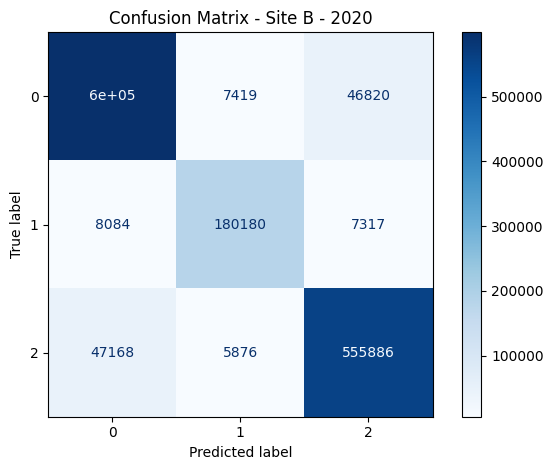


Training with 150000 samples...


Training Epoch 1: 100%|██████████| 2344/2344 [00:53<00:00, 44.12it/s]


Loss: 0.2159 + 1e-08 * 2591066.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.71it/s]


Epoch [1/15] Train Loss: 0.3071, Train Acc: 0.8909 | Val Loss: 0.2659, Val Acc: 0.9034


Training Epoch 2: 100%|██████████| 2344/2344 [00:53<00:00, 44.00it/s]


Loss: 0.2139 + 1e-08 * 2353573.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.20it/s]


Epoch [2/15] Train Loss: 0.2591, Train Acc: 0.9072 | Val Loss: 0.2574, Val Acc: 0.9087


Training Epoch 3: 100%|██████████| 2344/2344 [00:53<00:00, 44.03it/s]


Loss: 0.1784 + 1e-08 * 2194271.75


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.63it/s]


Epoch [3/15] Train Loss: 0.2444, Train Acc: 0.9124 | Val Loss: 0.2458, Val Acc: 0.9123


Training Epoch 4: 100%|██████████| 2344/2344 [00:53<00:00, 44.05it/s]


Loss: 0.1796 + 1e-08 * 2089467.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [4/15] Train Loss: 0.2356, Train Acc: 0.9148 | Val Loss: 0.2423, Val Acc: 0.9132


Training Epoch 5: 100%|██████████| 2344/2344 [00:53<00:00, 43.89it/s]


Loss: 0.1765 + 1e-08 * 2017243.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.17it/s]


Epoch [5/15] Train Loss: 0.2275, Train Acc: 0.9173 | Val Loss: 0.2441, Val Acc: 0.9110


Training Epoch 6: 100%|██████████| 2344/2344 [00:53<00:00, 43.79it/s]


Loss: 0.2415 + 1e-08 * 1967738.625


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.99it/s]


Epoch [6/15] Train Loss: 0.2212, Train Acc: 0.9200 | Val Loss: 0.2455, Val Acc: 0.9093


Training Epoch 7: 100%|██████████| 2344/2344 [00:53<00:00, 43.77it/s]


Loss: 0.1754 + 1e-08 * 1942255.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.14it/s]


Epoch [7/15] Train Loss: 0.2167, Train Acc: 0.9212 | Val Loss: 0.2387, Val Acc: 0.9132


Training Epoch 8: 100%|██████████| 2344/2344 [00:53<00:00, 44.11it/s]


Loss: 0.1246 + 1e-08 * 1920397.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.39it/s]


Epoch [8/15] Train Loss: 0.2121, Train Acc: 0.9224 | Val Loss: 0.2393, Val Acc: 0.9128


Training Epoch 9: 100%|██████████| 2344/2344 [00:53<00:00, 44.08it/s]


Loss: 0.2887 + 1e-08 * 1913734.125


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.08it/s]


Epoch [9/15] Train Loss: 0.2081, Train Acc: 0.9240 | Val Loss: 0.2330, Val Acc: 0.9153


Training Epoch 10: 100%|██████████| 2344/2344 [00:53<00:00, 44.10it/s]


Loss: 0.1370 + 1e-08 * 1915843.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.30it/s]


Epoch [10/15] Train Loss: 0.2038, Train Acc: 0.9266 | Val Loss: 0.2386, Val Acc: 0.9123


Training Epoch 11: 100%|██████████| 2344/2344 [00:53<00:00, 44.02it/s]


Loss: 0.2469 + 1e-08 * 1922520.875


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.68it/s]


Epoch [11/15] Train Loss: 0.1992, Train Acc: 0.9283 | Val Loss: 0.2351, Val Acc: 0.9157


Training Epoch 12: 100%|██████████| 2344/2344 [00:53<00:00, 43.95it/s]


Loss: 0.2688 + 1e-08 * 1935575.0


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.68it/s]


Epoch [12/15] Train Loss: 0.1948, Train Acc: 0.9295 | Val Loss: 0.2368, Val Acc: 0.9148


Training Epoch 13: 100%|██████████| 2344/2344 [00:53<00:00, 44.01it/s]


Loss: 0.1349 + 1e-08 * 1956733.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 144.41it/s]


Epoch [13/15] Train Loss: 0.1913, Train Acc: 0.9313 | Val Loss: 0.2504, Val Acc: 0.9118


Training Epoch 14: 100%|██████████| 2344/2344 [00:53<00:00, 43.98it/s]


Loss: 0.1396 + 1e-08 * 1981104.5


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.97it/s]


Epoch [14/15] Train Loss: 0.1876, Train Acc: 0.9328 | Val Loss: 0.2368, Val Acc: 0.9159


Training Epoch 15: 100%|██████████| 2344/2344 [00:53<00:00, 43.99it/s]


Loss: 0.1503 + 1e-08 * 2012101.375


Validation: 100%|██████████| 1519/1519 [00:10<00:00, 143.87it/s]


Epoch [15/15] Train Loss: 0.1845, Train Acc: 0.9342 | Val Loss: 0.2417, Val Acc: 0.9124


Stochastic Validation (T=15): 100%|██████████| 22778/22778 [02:41<00:00, 141.43it/s]


Stochastic Accuracy (mean over T): 0.9124
Cohen's Kappa: 0.8561
Per-class F1: [0.9133027  0.9153558  0.91047048]
Average F1 (macro): 0.9130


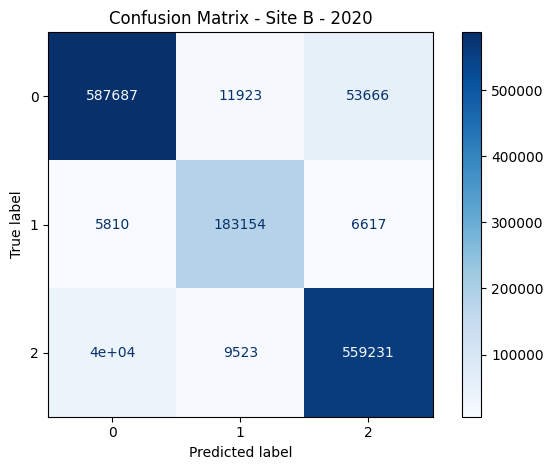

In [29]:
# Subsampled Training
if flag_subsampled:
    elbow_history = subsampled_training(X_train, y_train, val_dataloader, start=15000, end=150000, step=15000)
    
else: 
    # Simple training
    train_losses, val_losses, train_accs, val_accs = train(model, train_dataset, train_dataloader, val_dataloader, optimizer, KL_WEIGHT=KL_WEIGHT, EPOCHS=EPOCHS, T=T)

    acc, kappa, per_class_f1, avg_f1, cm = evaluate(model, test_dataloader, T, device=DEVICE)
    
    # Printing and plotting
    print("Stochastic" + f" Accuracy (mean over T): {acc:.4f}" if (T>1) else "Deterministic" + f" Accuracy (mean over T): {acc:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Per-class F1: {per_class_f1}")
    print(f"Average F1 (macro): {avg_f1:.4f}")
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Site {SITE} - {YEAR}")
    plt.tight_layout()
    plt.show()

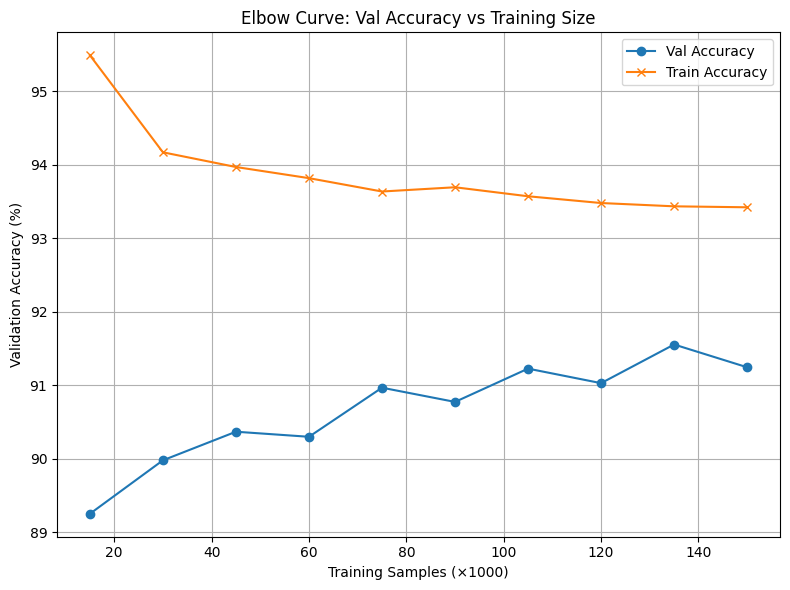

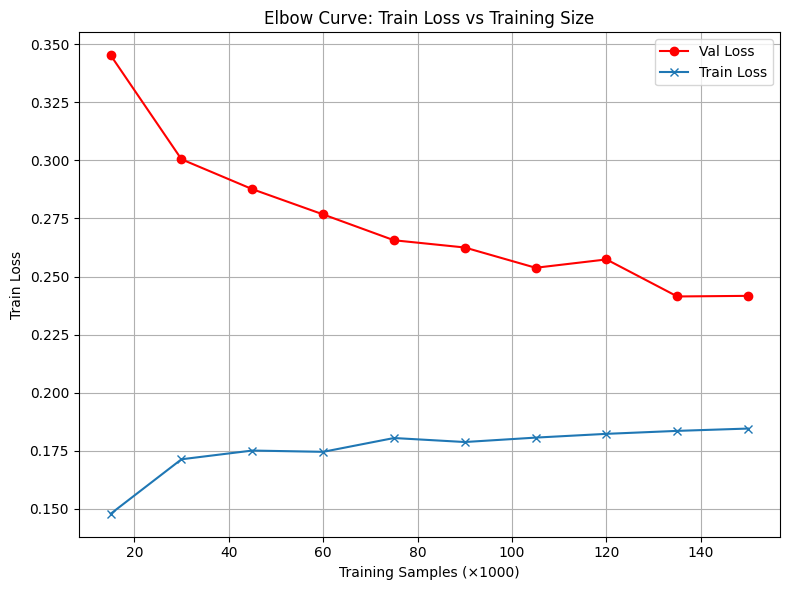

In [30]:
if flag_subsampled:
    def plot_elbow_curve(elbow_history):
        x_vals = [x / 1000 for x in elbow_history["subset_size"]]
    
        # Accuracy
        plt.figure(figsize=(8, 6))
        y_vals = [acc * 100 for acc in elbow_history["val_accuracy"]]
        plt.plot(x_vals, y_vals, marker='o', label='Val Accuracy')
        plt.plot(x_vals, [acc * 100 for acc in elbow_history['train_accuracy']], marker='x', label='Train Accuracy')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Validation Accuracy (%)")
        plt.title("Elbow Curve: Val Accuracy vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
        # Train Loss
        plt.figure(figsize=(8, 6))
        y_vals = elbow_history["val_loss"]  # raw loss
        plt.plot(x_vals, y_vals, marker='o', color='red', label='Val Loss')
        plt.plot(x_vals, elbow_history["train_loss"], marker='x', label='Train Loss')
        plt.xlabel("Training Samples (×1000)")
        plt.ylabel("Train Loss")
        plt.title("Elbow Curve: Train Loss vs Training Size")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    plot_elbow_curve(elbow_history)

else: 
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Val Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Val Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

## Saving Results

In [31]:
if flag_subsampled:
    def save_elbow_results_to_excel(filename, elbow_history):
        # Load or create workbook
        if os.path.exists(filename):
            wb = load_workbook(filename)
            ws = wb.active
        else:
            wb = Workbook()
            ws = wb.active
    
            # Header row with bold font
            headers = ["Experiments", "Results"]
            bold_font = Font(bold=True)
            ws.append(headers)
    
            for col_num in range(1, len(headers) + 1):
                ws.cell(row=1, column=col_num).font = bold_font
    
        # For each subset size, append a row
        for i in range(len(elbow_history["subset_size"])):
            subset = elbow_history["subset_size"][i]
            train_acc = elbow_history["train_accuracy"][i] * 100
            train_loss = elbow_history["train_loss"][i]
            val_acc = elbow_history["val_accuracy"][i] * 100
            val_loss = elbow_history["val_loss"][i]
            val_avg_f1 = elbow_history["val_avg_f1"][i] * 100
            kappa = elbow_history["kappa"][i]
    
    
            experiment_name = f"Labeled Samples: {subset}"
            results_str = (
                f"TrainAcc = {train_acc:.2f}%, "
                f"TrainLoss = {train_loss:.4f},\n"
                f"ValAcc = {val_acc:.2f}%, "
                f"ValLoss = {val_loss:.4f},\n"
                f"AvgF1 = {val_avg_f1:.2f}%, "
                f"Kappa = {kappa:.4f}"
            )
    
            ws.append([experiment_name, results_str])
    
        wb.save(filename)
        print(f"Results saved to {filename}")
    
save_elbow_results_to_excel(
    filename="Results.xlsx",
    elbow_history=elbow_history
)

Results saved to Results.xlsx


<hr>